# DQN Atari Paper Implementation

In [38]:
# ! pip install gymnasium[atari] torch numpy

In [39]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

## Hyperparameters
As per the paper, we use certain hyperparameters that were tuned across various Atari games.

In [40]:
LEARNING_RATE = 0.00025  # Paper used a similar learning rate
DISCOUNT_FACTOR = 0.99  # The γ discount factor as mentioned in the paper
REPLAY_MEMORY_SIZE = 1_000_000  # Large replay buffer as described
BATCH_SIZE = 32  # Minibatch size for training
TARGET_UPDATE_FREQ = 10_000  # C steps for target network update
FRAME_SKIP = 4  # Number of frames skipped
EPSILON_DECAY = 0.999995  # Epsilon decay for exploration-exploitation tradeoff
MIN_EPSILON = 0.1  # Minimum value of epsilon (for more exploitation)
MAX_EPSILON = 1.0  # Starting value of epsilon (for exploration)
MAX_STEPS = 520_000  # Total training episodes (Space Invaders)
REPLAY_START_SIZE = 50_000  # Size of replay memory before starting training
SAVE_FREQUENCY = 50_000  # Save model every 50k steps

## Deep Q-Network Architecture
Referring to the paper's architecture (3 convolutional layers, followed by fully connected layers)

In [41]:
class DQN(nn.Module):
    def __init__(self, action_space):
        super(DQN, self).__init__()
        # The first convolution layer (as per paper), input: 84x84x4 image, 32 filters of 8x8, stride 4
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        # The second convolution layer, 64 filters of 4x4, stride 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        # The third convolution layer, 64 filters of 3x3, stride 1
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        # Fully connected layer with 512 units (as described in the paper)
        self.fc1 = nn.Linear(3136, 512)
        # Final fully connected layer with one output for each action
        self.fc2 = nn.Linear(512, action_space)

    def forward(self, x):
        # Using ReLU activations as specified in the paper
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flattening
        x = torch.relu(self.fc1(x))
        return self.fc2(x)  # Outputs the Q-values for each action

## Custom Wrappers
We use custom wrappers using gymnasium's API.
The paper describes preprocessing the input frames by converting them to grayscale, resizing, normalizing and stacking the last 4 frames to capture motion. We will use the same preprocessing steps.

In [42]:
class FrameSkip(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        super(FrameSkip, self).__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, sum reward, and take the last observation."""
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, truncated, info = self.env.step(action)
            total_reward += reward
            if done or truncated:
                break
        return obs, total_reward, done, truncated, info


class GrayScaleResize(gym.ObservationWrapper):
    def __init__(self, env):
        """Convert the observations to grayscale and resize to 84x84."""
        super(GrayScaleResize, self).__init__(env)
        self.observation_space = gym.spaces.Box(
            low=0, high=255, shape=(84, 84), dtype=np.uint8
        )

    def observation(self, obs):
        obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
        obs = cv2.resize(obs, (84, 84), interpolation=cv2.INTER_AREA)  # Resize to 84x84
        return obs


class FrameStack(gym.Wrapper):
    def __init__(self, env, k=4):
        """Stack `k` last frames."""
        super(FrameStack, self).__init__(env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=0, high=255, shape=(k, shp[0], shp[1]), dtype=np.uint8
        )

    def reset(self):
        obs, _ = self.env.reset()
        for _ in range(self.k):
            self.frames.append(obs)
        return self._get_ob()

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        self.frames.append(obs)
        return self._get_ob(), reward, done, truncated, info

    def _get_ob(self):
        return np.array(self.frames)


class NormalizeObs(gym.ObservationWrapper):
    """Normalize observations to the range [0, 1]."""

    def __init__(self, env):
        super(NormalizeObs, self).__init__(env)
        self.observation_space = gym.spaces.Box(
            low=0, high=1.0, shape=env.observation_space.shape, dtype=np.float32
        )

    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0

## Replay Memory
We implement an experience replay buffer as described in the paper to store past experiences and sample them randomly during training to break the correlation between consecutive frames.

In [43]:
class ReplayBuffer:
    def __init__(self, size):
        self.buffer = deque(maxlen=size)  # Circular buffer with max size

    def add(self, experience):
        self.buffer.append(experience)  # Add new experience

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        return [self.buffer[idx] for idx in indices]  # Sample random minibatch

    def __len__(self):
        return len(self.buffer)

## Epsilon-greedy action selection
This function selects an action using epsilon-greedy policy as mentioned in the paper.

In [44]:
def select_action(state, policy_net, epsilon, action_space):
    if random.random() < epsilon:  # Explore
        return random.choice(action_space)
    else:  # Exploit
        with torch.no_grad():
            return policy_net(state).argmax(dim=1).item()

## Target Network Update
Target network helps stabilize learning. The paper mentions that the target network is updated every C steps.

In [45]:
def update_target(policy_net, target_net):
    target_net.load_state_dict(policy_net.state_dict())  # Sync the weights

## Gymnasium Environment Setup

Here we set up the gym environment, by selecting the Breakout game. We specify RMSProp as the optimizer just like in the paper training details.

In [46]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

In [47]:
def make_env(env_id, render_mode=None, frame_skip=4):
    """Create environment with preprocessing wrappers."""
    env = gym.make(env_id, render_mode=render_mode)
    env = FrameSkip(env, skip=frame_skip)  # Frame skipping (skip 4 frames)
    env = GrayScaleResize(env)  # Convert frames to grayscale and resize to 84x84
    env = NormalizeObs(env)  # Normalize pixel values to [0, 1]
    env = FrameStack(env, k=4)  # Stack the last 4 frames
    return env


env = make_env("ALE/Breakout-v5")
action_space = [i for i in range(env.action_space.n)]

# Initialize policy and target networks
policy_net = DQN(len(action_space)).to(device)
target_net = DQN(len(action_space)).to(device)
update_target(policy_net, target_net)  # First sync

optimizer = optim.RMSprop(policy_net.parameters(), lr=LEARNING_RATE)
replay_buffer = ReplayBuffer(REPLAY_MEMORY_SIZE)

epsilon = MAX_EPSILON  # Starting value of epsilon

## Training Loop
Here, we follow the methodology from the paper, by putting all the above components together to train the DQN agent on the Atari game.

In [48]:
def batch_to_tensor(batch):
    batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*batch)

    batch_state = torch.cat(batch_state)
    batch_action = torch.tensor(batch_action).unsqueeze(1).to(device)
    batch_reward = torch.tensor(batch_reward).to(device)
    batch_next_state = torch.cat(batch_next_state)
    batch_done = torch.tensor(batch_done).to(device)

    return batch_state, batch_action, batch_reward, batch_next_state, batch_done

In [37]:
total_steps = 0

plot_infos = {"total_steps": [], "total_reward": [], "epsilon": []}

progress_bar = tqdm(range(MAX_STEPS), desc="Training Progress")

while total_steps < MAX_STEPS:
    state = env.reset()  # Reset environment to initial state
    state = (
        torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    )  # Shape [1, 4, 84, 84]

    total_reward = 0

    while True:
        action = select_action(state, policy_net, epsilon, action_space)

        # Step the environment
        next_state, reward, done, truncated, _ = env.step(action)
        next_state = (
            torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)
        )

        # Store the transition in replay memory
        replay_buffer.add((state, action, reward, next_state, done))

        state = next_state
        total_reward += reward
        total_steps += 1

        # Only start training when replay memory has enough samples
        if len(replay_buffer) >= REPLAY_START_SIZE:
            # Sample minibatch from replay buffer
            batch = replay_buffer.sample(BATCH_SIZE)

            batch_state, batch_action, batch_reward, batch_next_state, batch_done = (
                batch_to_tensor(batch)
            )
            # Compute Q targets
            q_values = policy_net(batch_state).gather(1, batch_action)
            next_q_values = target_net(batch_next_state).max(1)[0].detach()
            target_q_values = batch_reward + (
                DISCOUNT_FACTOR * next_q_values * torch.logical_not(batch_done)
            )

            # Loss is the squared error as mentioned in the paper
            loss = nn.MSELoss()(q_values.squeeze(), target_q_values)

            # Backpropagate and update the network
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update target network periodically
            if total_steps % TARGET_UPDATE_FREQ == 0:
                update_target(policy_net, target_net)

            # Save checkpoints every SAVE_FREQUENCY steps
            if total_steps % SAVE_FREQUENCY == 0:
                torch.save(
                    policy_net.state_dict(), f"checkpoints/checkpoint_{total_steps}.pth"
                )

        if done or truncated:
            break

    # Append the total reward for tracking
    plot_infos["total_reward"].append(total_reward)
    # Decay epsilon for exploration-exploitation tradeoff
    epsilon = max(MIN_EPSILON, epsilon * EPSILON_DECAY)
    plot_infos["epsilon"].append(epsilon)
    plot_infos["total_steps"].append(total_steps)

    progress_bar.set_description(f"R: {plot_infos['total_reward'][-1]}, ε: {plot_infos['epsilon'][-1]:.5f}")
    progress_bar.update(plot_infos["total_steps"][-1] - progress_bar.n)

progress_bar.close()
env.close()

R: 3.0, ε: 0.99996:   0%|          | 578/520000 [00:00<11:59, 721.80it/s]

KeyboardInterrupt: 

R: 3.0, ε: 0.99996:   0%|          | 578/520000 [00:20<11:59, 721.80it/s]

## Training Progress

Here is the training progress of the DQN agent on the Breakout game.

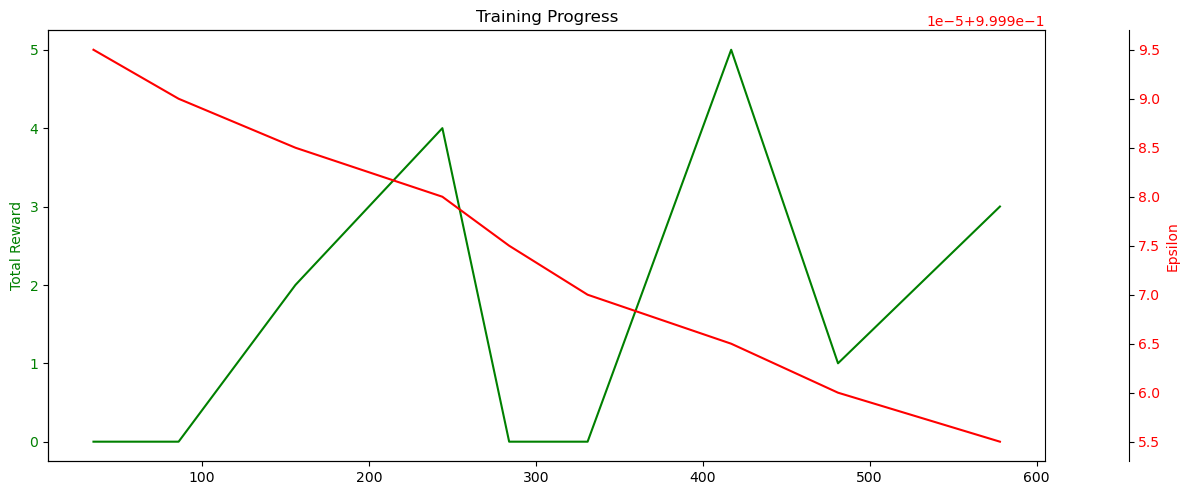

In [49]:
fig, ax1 = plt.subplots(figsize=(12, 5))

# Create a secondary y-axis for total rewards
ax1.plot(plot_infos['total_steps'], plot_infos['total_reward'], label='Total Reward', color='green')
ax1.set_ylabel('Total Reward', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Create another secondary y-axis for epsilon values
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('outward', 60))
ax2.plot(plot_infos['total_steps'], plot_infos['epsilon'], label='Epsilon', color='red')
ax2.set_ylabel('Epsilon', color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.tight_layout()
plt.title('Training Progress')
plt.show()

## Result
Here is the training playing each 50000 steps.

In [50]:
import glob
import torch
import os

# Path to checkpoints directory
CHECKPOINT_DIR = "checkpoints"

# Function to load model weights from checkpoint file
def load_checkpoint(model, checkpoint_file):
    model.load_state_dict(torch.load(checkpoint_file))
    model.eval()  # Set the model to evaluation mode (important for inference)

# Function to play the game using the loaded model
def play_episode(env, model):
    obs = env.reset()
    state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)  # Initial state, [1, 4, 84, 84]
    total_reward = 0

    done = False
    while not done:
        with torch.no_grad():
            action = model(state).argmax(dim=1).item()  # Select action with highest Q-value
        next_state, reward, done, truncated, _ = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)
        state = next_state
        total_reward += reward
        if done or truncated:
            break

    return total_reward

# Iterate over each checkpoint file and run the evaluation
def evaluate_checkpoints(checkpoint_dir):
    # Glob all checkpoint files in the directory
    checkpoint_files = glob.glob(os.path.join(checkpoint_dir, "*.pth"))
    
    # Sort the checkpoint files if needed
    checkpoint_files.sort()

    # Create the environment
    env = make_env("ALE/Breakout-v5", render_mode="human", frame_skip=1)

    # Initialize DQN model (same as the one used during training)
    action_space = env.action_space.n
    model = DQN(action_space).to(device)  # Create the DQN model

    for checkpoint in checkpoint_files:
        print(f"Loading checkpoint: {checkpoint}")
        # Load the model weights from the checkpoint file
        load_checkpoint(model, checkpoint)

        # Play one episode with the loaded model and print the total reward
        total_reward = play_episode(env, model)
        print(f"Checkpoint {checkpoint}: Total Reward = {total_reward}")

    env.close()

# Call the function to evaluate the checkpoints
evaluate_checkpoints(CHECKPOINT_DIR)

Loading checkpoint: checkpoints/checkpoint_50000.pth


/var/folders/mv/3fqdyl697kg4mqs3tkmd7gs80000gn/T/ipykernel_27239/539030423.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_f

: 